In [1]:
import numpy as np
from abc import ABC, abstractmethod, abstractproperty
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

In [2]:
class Firefly(ABC):
    
    #-------- Abstract properties --------#
    
    
    #-------- Abstract methods --------#
    

SyntaxError: unexpected EOF while parsing (<ipython-input-2-96b1434ec208>, line 7)

In [ ]:
class FemaleFirefly(Firefly):
    

In [ ]:
class MaleFireflY(Firefly):
    

## Converting original MATLAB/R code to Python

### 1. Male firefly correlated random walk

In [3]:
# Parameters
# Based on these params, a firefly takes 1000 steps and flash every 100 steps (10x)
N = 1000           # Number of steps per trajectory
REALIZATIONS = 20  # Number of fireflies in arena 
v = 1.0            # Velocity aka step size
NreS = 100         # Number of steps bw flashes
sigma02 = np.pi/10 # Width of random walk turning angle distribution. Lower: straighter.

initial_arena_size = N

In [20]:
# Correlated random walks
np.random.seed(42)

x = np.zeros((REALIZATIONS, N))
y = np.zeros((REALIZATIONS, N))
theta = np.zeros((REALIZATIONS, N))

# Pick random initial positions for all male FF (convert to - to + coordinates)
x[:,0] = initial_arena_size * (np.random.rand(x.shape[0]) - 0.5)
y[:,0] = initial_arena_size * (np.random.rand(y.shape[0]) - 0.5)
theta[:,0] = np.pi * (np.random.rand(theta.shape[0]) - 0.5)

# Loop over each male firefly
for realization_i in range(REALIZATIONS):
    
    # Each FF takes N steps total
    for step_i in range(1, N):
        
        # At each step, it chooses a random turning angle (radians)
        theta[realization_i, step_i] = theta[realization_i, step_i-1] + sigma02 * 2 * (np.random.rand()-0.5)
        
        # Update x and y position according to theta
        x[realization_i, step_i] = x[realization_i, step_i-1] + v * np.cos(theta[realization_i, step_i])
        y[realization_i, step_i] = y[realization_i, step_i-1] + v * np.sin(theta[realization_i, step_i])


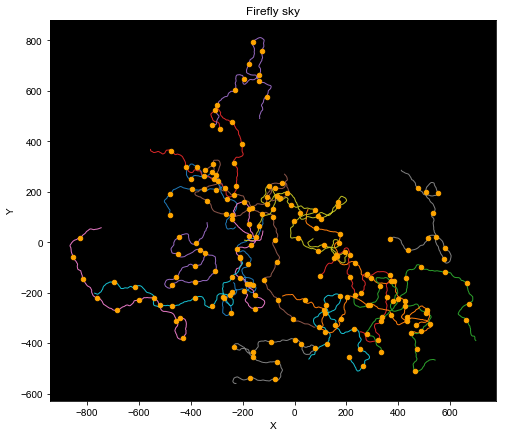

In [35]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1, 1, 1)

# Plot line tracks
plt.plot(x.T, y.T, lw=1, zorder=0, label="-")

# Plot flashing patterns
xx = x.T.copy()
yy = y.T.copy()
plt.scatter(xx[::NreS], yy[::NreS], c='orange', s=20)

plt.xlabel('X')
plt.ylabel('Y')

ax = plt.gca()
ax.set_facecolor('xkcd:black')

# plt.legend(loc=(1.01,.1), title=("Male firefly"))
plt.title('Firefly sky')
plt.show()

At first flashes, (assume synchronized flashing?) female picks a single male and attempts to track him until the end of simulation? At each time, firefly makes a guess on most likely male based on flash location, and build a history of that track